In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import scipy.interpolate
import scipy.integrate
import seaborn as sns

In [2]:
m = 1.4e3  # [kg] - effective vehicle mass
c_r = 12e-3  # [-] - tire rolling resistance coefficient
c_D = 0.3  # [-] - aerodynamic drag coefficient
A_f = 2.2  # [m^2] - frontal area

P_max = 100e3  # [W] - maximum powertrain output power
mu_max = 1  # [-] - maximum tire adhesion coefficient

rho = 1.2  # [kg/m^3] - density of ambient air
g = 9.81  # [m/s^2] - earth acceleration

# Serial HEV with the ICE turned off

Let's generate a simple driving cycle, i.e. a speed signal $v(t_k)$. We are going to accelerate our vehicle from rest to $50 km/h$ at an acceleration of $0.08 \; g$, keep that velocity for a while, brake to a halt, and then accelerate again to $50 \; km/h$:

In [3]:
t_0_to_50 = 50/3.6 / (g * 0.08)

In [4]:
v = np.array([0, 0, 50, 50, 0, 0, 50, 50])/3.6
t = np.array([0, 10, 10 + t_0_to_50, 60, 60 + t_0_to_50 / 2, 120, 120 + t_0_to_50, 300])
v = scipy.interpolate.interp1d(t, v)
t = np.linspace(0, 200, 1001)
v = v(t)

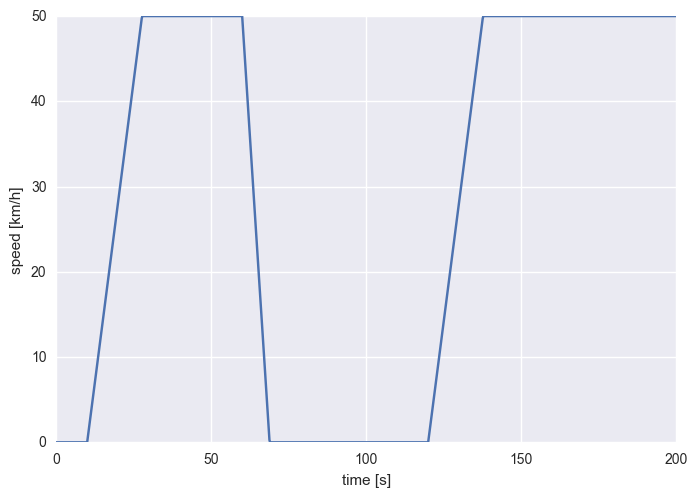

In [5]:
ax = plt.subplot(111)
ax.plot(t, v*3.6)
ax.set_xlabel("time [s]")
ax.set_ylabel("speed [km/h]")

THis gives us the following acceleration $a(t)$:

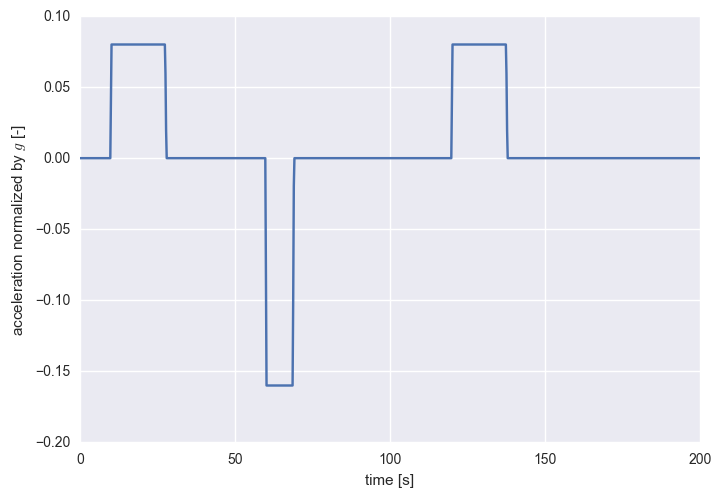

In [6]:
a = np.gradient(v, np.mean(np.diff(t)))

ax = plt.subplot(111)
ax.plot(t, a/g)
ax.set_xlabel("time [s]")
ax.set_ylabel("acceleration normalized by $g$ [-]")

From there we calculate the rolling resistance, aerodynamic drag and inertial forces the vehicle has to apply to the road to follow this driving cycle. By multiplying by force we arrive at the propulsion power, the powertrain has to providE:

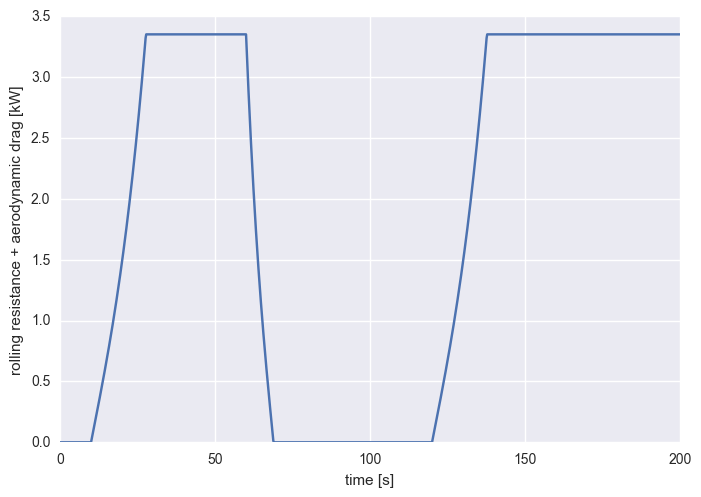

In [7]:
F_aero = 1/2 * c_D * A_f * rho * v**2
F_roll = m * g * c_r
P_drag = (F_aero + F_roll) * v

ax = plt.subplot(111)
ax.plot(t, P_drag*1e-3)
ax.set_xlabel("time [s]")
ax.set_ylabel("rolling resistance + aerodynamic drag [kW]")

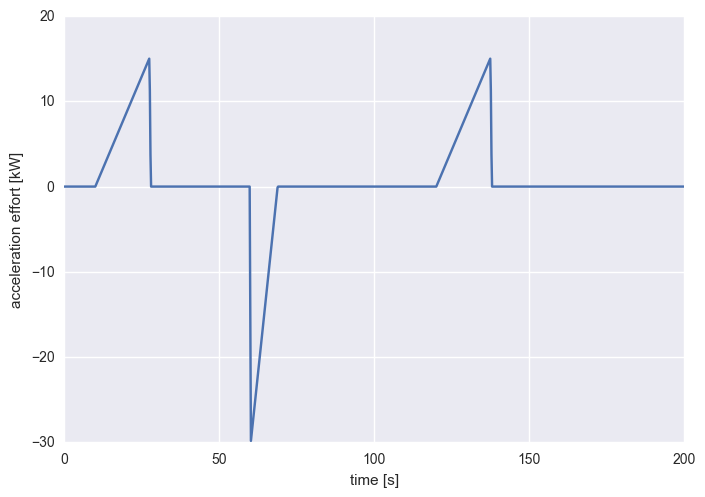

In [8]:
P_acc = m * a * v

ax = plt.subplot(111)
ax.plot(t, P_acc*1e-3)
ax.set_xlabel("time [s]")
ax.set_ylabel("acceleration effort [kW]")

Finally, we arrive at the total propulsive power. If, in a series hybrid, the ICE is not running, then all power has to be supplied by the battery. The propulsion power is thus equal to the flow from the battery (i.e. positive values mean the battery is discharged).

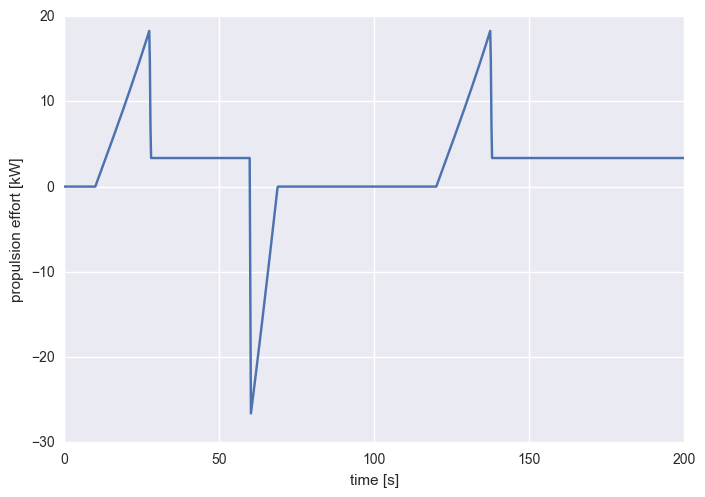

In [9]:
P_prop = P_acc + P_drag

ax = plt.subplot(111)
ax.plot(t, P_prop*1e-3)
ax.set_xlabel("time [s]")
ax.set_ylabel("propulsion effort [kW]")

From the above definition, the battery state of charge decreases, if the battery power flow is positive. The evolution of the battery state of charge is thus simply the integral over the opposite ($\cdot - 1$) of the propulsion power. In the resulting curve, $0$ corresponds to the initial state of charge. If we arrive (as we do) at $-0.10 \; kWh$ at the end, it means that we have to put $0.10 \; kWh$ into the battery to bring it back to its initial state (note that we are thus far disregarding the charging and dischargin losses).

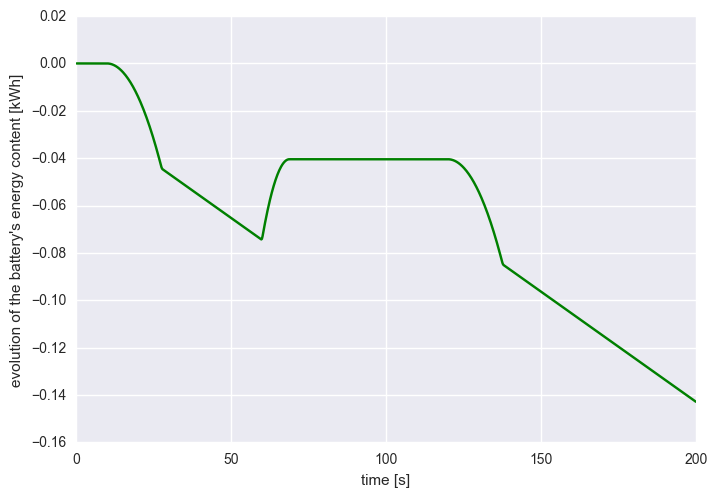

In [10]:
P_prop = P_acc + P_drag
E_batt = scipy.integrate.cumtrapz(-P_prop, t)

ax = plt.subplot(111)
ax.plot(t[1:], E_batt/3.6e6, "g")
ax.set_xlabel("time [s]")
ax.set_ylabel("evolution of the battery's energy content [kWh]")

# A simple thermostat strategy

We cannot keep driving forever without starting the ICE, as the battery will run dry at some point; or, more accurately, the SOC drops below its safe area of operation. Now where or what this safe area of operation really is, we don't really know - resp. we don't have the time to care about in this exercise. So we will do the conservative thing, and stay the hell away from it.

The simplest way to ensure this is a so-called thermostat strategy: the vehicle starts out with the ICE off. As soon as the SOC drops below a certain threshold, we start the ICE. We keep it running until the SOC climbs above a predefined setting. We then shut the ICE off, and go back to waiting for the SOC to drop below its lower threshold. This is the same procedure as e.g. in fridge thermostats - hence the name.

In the above example, let's assume that the initial $0 \; kWh$ corresponds to an SOC of say $0.5$, and we never want to get further away from that point than $0.05 ; kWh$. In other words, we'll set the lower threshold to $-0.05 \; kWh$, and the upper threshold to $+0.05 \; kWh$ (we use $dE_{batt}$ to denote the positive and negative deviation from zero we allow the battery to have).

If we apply this strategy to the above driving cycle with $dE_{batt} = 0.05 \; kWh$, brake energy recuperation pushes us out of the safe area of operation. There is nothing that the powertrain could do to prevent this. This would be an ill-designed strategy (we should go to a bigger $dE_{batt}$). If we go to $dE_{batt} = 0.07 \; kWh$, the ICE starts just before we start recuperating (at $t= 55\; s$) for the first time, and continues producing during the recuperation. The battery then has to absorb both the recuperated power, and the ICE's production. We thus just maximized the power flow to the battery. As we've seen in the lecture, battery losses increase with absolute power - thus we have just maximized our battery losses.

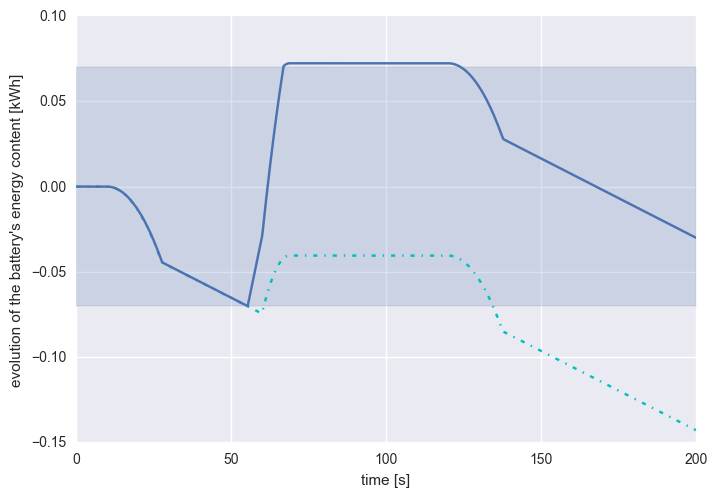

In [11]:
dE_batt = 0.07 * 3.6e6  # battery: safe area of operation around 0 J

n_steps = t.shape[0]  # number of time-steps
dt = np.mean(np.diff(t))  # time-step (difference between t_k and t_k+1)

E_batt_HEV = np.zeros(n_steps)  # initialize result vector - 0 = reference SOC
ICE_on = False  # state variable, for thermostat control

for k in range(n_steps-1):
    if ICE_on:  # if the ICE is running, keep it running until the SOC exceeds its upper threshold
        if E_batt_HEV[k] >= dE_batt:
            ICE_on = False
    else:  # if the ICE is not running, wait for the SOC to drop below its lower threshold
        if E_batt_HEV[k] <= -dE_batt:
            ICE_on = True

    P_ICE = 35e3 if ICE_on else 0  # set ICE power to nominal if it is running, else 0        
    E_batt_HEV[k+1] = E_batt_HEV[k] + (P_ICE - P_prop[k]) * dt  # Euler integration of power flow into the battery (> 0 = battery charges)

ax = plt.subplot(111)
ax.fill_between([t[0], t[-1]], -dE_batt*np.ones(2) / 3.6e6, dE_batt*np.ones(2) / 3.6e6, alpha=0.2)
ax.plot(t[1:], E_batt/3.6e6, "c-.")
ax.plot(t, E_batt_HEV/3.6e6)
ax.set_xlabel("time [s]")
ax.set_ylabel("evolution of the battery's energy content [kWh]")

In [12]:
t[np.nonzero(E_batt <= -dE_batt)[0][0]]

55.0

## Preventing production while recuperating

Now we could augment the above strategy to prevent production during recuperation. It is a simple matter of adding an additional if-block in the code: if $P_{prop}$ is negative, always turn off the ICE (added in line 17). Note that, with this particular formulation, the ICE won't resume production after the recuperation event, because we are over tue lower limit.

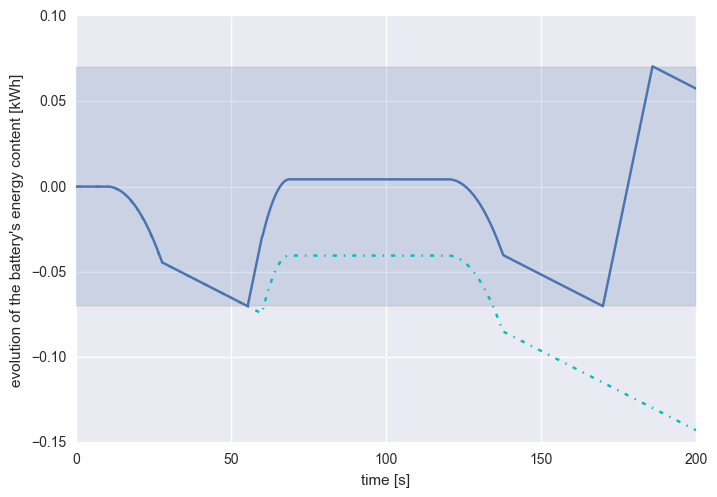

In [13]:
dE_batt = 0.07 * 3.6e6  # battery: safe area of operation around 0 J

n_steps = t.shape[0]  # number of time-steps
dt = np.mean(np.diff(t))  # time-step (difference between t_k and t_k+1)

E_batt_HEV = np.zeros(n_steps)  # initialize result vector - 0 = reference SOC
ICE_on = False  # state variable, for thermostat control

for k in range(n_steps-1):
    if ICE_on:  # if the ICE is running, keep it running until the SOC exceeds its upper threshold
        if E_batt_HEV[k] >= dE_batt:
            ICE_on = False
    else:  # if the ICE is not running, wait for the SOC to drop below its lower threshold
        if E_batt_HEV[k] <= -dE_batt:
            ICE_on = True
            
    if P_prop[k] < 0:  # whatever state we are at, make sure the ICE is off when we are braking
        ICE_on = False

    P_ICE = 35e3 if ICE_on else 0  # set ICE power to nominal if it is running, else 0        
    E_batt_HEV[k+1] = E_batt_HEV[k] + (P_ICE - P_prop[k]) * dt  # Euler integration of power flow into the battery (> 0 = battery charges)

ax = plt.subplot(111)
ax.fill_between([t[0], t[-1]], -dE_batt*np.ones(2) / 3.6e6, dE_batt*np.ones(2) / 3.6e6, alpha=0.2)
ax.plot(t[1:], E_batt/3.6e6, "c-.")
ax.plot(t, E_batt_HEV/3.6e6)
ax.set_xlabel("time [s]")
ax.set_ylabel("evolution of the battery's energy content [kWh]")

## A more gentle controller - at least to the battery

The above formulation still fires the ICE's full $35 \; kW$ output power into the battery, no matter the current power flow to the wheels. If we want to maximize battery efficiency by minimizing the power flow to the battery, then a so-called load-following thermostat control is a simple workaround. For this, we go back to the initial controller (although it can also be constructed with the additional 'not-during-recuepration' constraint). We change line 17, so that it no longer just runs the ICE at full load, but now produces exactly $1 \; kW$ more than required by the wheel (i.e. it enforces a charging power of $1 \; kW$). Of course this only works until we reach the ICE's maximum output power.

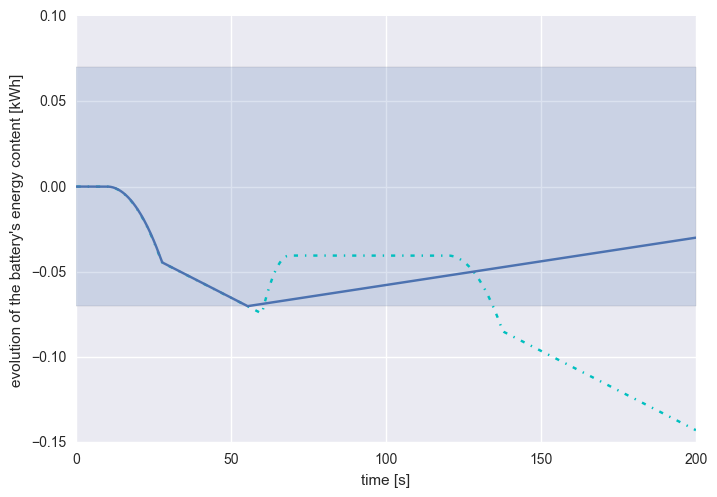

In [14]:
dE_batt = 0.07 * 3.6e6  # battery: safe area of operation around 0 J

n_steps = t.shape[0]  # number of time-steps
dt = np.mean(np.diff(t))  # time-step (difference between t_k and t_k+1)

E_batt_HEV = np.zeros(n_steps)  # initialize result vector - 0 = reference SOC
ICE_on = False  # state variable, for thermostat control

for k in range(n_steps-1):
    if ICE_on:  # if the ICE is running, keep it running until the SOC exceeds its upper threshold
        if E_batt_HEV[k] >= dE_batt:
            ICE_on = False
    else:  # if the ICE is not running, wait for the SOC to drop below its lower threshold
        if E_batt_HEV[k] <= -dE_batt:
            ICE_on = True

    P_ICE = np.minimum(P_prop[k] + 1e3, 35e3) if ICE_on else 0  # sets ICE power to P_prop + 1e3, but maximally 35e3 W if ICE_on
    E_batt_HEV[k+1] = E_batt_HEV[k] + (P_ICE - P_prop[k]) * dt  # Euler integration of power flow into the battery (> 0 = battery charges)

ax = plt.subplot(111)
ax.fill_between([t[0], t[-1]], -dE_batt*np.ones(2) / 3.6e6, dE_batt*np.ones(2) / 3.6e6, alpha=0.2)
ax.plot(t[1:], E_batt/3.6e6, "c-.")
ax.plot(t, E_batt_HEV/3.6e6)
ax.set_xlabel("time [s]")
ax.set_ylabel("evolution of the battery's energy content [kWh]")